# Section 1 - Quantifying the association of a feature with an outcome

## Example 1.3

**Application 1.3**: We hypothesize that misfolding occurs preferentially in the entangled regions of a protein's primary structure

* This hypothesis is related to the hypothesis stated in **Application 1.1**; in this case, rather than considering whether each protein is entangled, we consider here individual amino acids and whether each is involved in an entanglement (detected by analysis of protein structures) and is misfolded (again from LiP-MS experiments).

* Take a moment to think - **what should your contingency table look like?** What are the columns, and what are the rows?

* Carry out this last example solo by running each of the following cells in sequence
* Once you have obtained the result at the end, try explaining your conclusions to at least one person sitting near you

### Step 0 - Load libraries

* We first need to make sure we have access to all of the functions etc. that we need for this analysis - let's load some libraries

In [1]:
import numpy as np
import pandas as pd
from scipy.stats import fisher_exact
import matplotlib.pyplot as plt

### Step 1 - Load the data
* We will use a data set containing per-residue information on entanglements and misfolding from Lip-MS

In [2]:
# data3 is a pandas DataFrame object
data_path = "/home/jovyan/data-store/data/iplant/home/shared/NCEMS/BPS-training-2025/"
data3     = pd.read_csv(data_path+"Ecoli_entanglement_data.csv")

### Step 2 - Explore the data
* Run a few simple commands to learn more about the data set

In [3]:
# first, print a quick summary
print ("Create a quick summary of the DataFrame:\n")
data3.info()

# second, print the first 10 rows of the DataFrame
print ("\nPrint the first 10 rows of the DataFrame:\n")
data3.head(10)

Create a quick summary of the DataFrame:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 384582 entries, 0 to 384581
Data columns (total 14 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   gene                     384582 non-null  object 
 1   pdb                      384582 non-null  object 
 2   chain                    384582 non-null  object 
 3   uniprot_length           384582 non-null  int64  
 4   ent_present              384582 non-null  bool   
 5   pdb_resid                384582 non-null  int64  
 6   resname                  384582 non-null  object 
 7   AA                       384579 non-null  object 
 8   region                   384582 non-null  int64  
 9   mapped_resid             379789 non-null  float64
 10  cut_C_Rall               384582 non-null  bool   
 11  cut_CD_Rall              384582 non-null  bool   
 12  cut_CG_Rall              384582 non-null  bool   
 13  num_unique_entang

,gene,pdb,chain,uniprot_length,ent_present,pdb_resid,resname,AA,region,mapped_resid,cut_C_Rall,cut_CD_Rall,cut_CG_Rall,num_unique_entanglement
0,A5A616,5OQT,C,31,False,1,MET,M,0,1.0,False,False,False,0
1,A5A616,5OQT,C,31,False,2,LEU,L,0,2.0,False,False,False,0
2,A5A616,5OQT,C,31,False,3,GLY,G,0,3.0,False,False,False,0
3,A5A616,5OQT,C,31,False,4,ASN,N,0,4.0,False,False,False,0
4,A5A616,5OQT,C,31,False,5,MET,M,0,5.0,False,False,False,0
5,A5A616,5OQT,C,31,False,6,ASN,N,0,6.0,False,False,False,0
6,A5A616,5OQT,C,31,False,7,VAL,V,0,7.0,False,False,False,0
7,A5A616,5OQT,C,31,False,8,PHE,F,0,8.0,False,False,False,0
8,A5A616,5OQT,C,31,False,9,MET,M,0,9.0,False,False,False,0
9,A5A616,5OQT,C,31,False,10,ALA,A,0,10.0,False,False,False,0


* Consider the output from these commands - what can you learn about the data set we are using? (Consider, for example, the line in the output of `data3.info()` for `mapped_resid`).

* There are many columns in this file, but we only need a few: (1) `region` indicates whether an entanglement is present (`True`) or absent (`False`) at a residue; (2) `cut_C_Rall` indicates whether misfolding is detected at this residue by LiP-MS in the absence of chaperones.

* `cut_CD_Rall` & `cut_CG_Rall` indicate whether misfolding is detected at a residue in the presence of the molecular chaperones DnaK/J & GroEL/ES, respectively. We will only consider the chaperone-free case here.

* For these data, we need to do two additional processing steps to (1) remove rows of the DataFrame `data3` that are associated with proteins that had either low coverage or low abundance in the LiP-MS experiment and (2) remove rows of `data3` that correspond to amino acids present in the protein crystal structure but not in the UniProt sequence of the protein:

In [4]:
# filter to remove proteins that have low abundance or coverage in LiP-MS experiments

# load a data set that contains a list of the high-quality proteins from LiP-MS
data3_mask = pd.read_csv(data_path+"Ecoli_C_high-abundance_high-coverage.txt")

# keep only entries that correspond to high-quality proteins from LiP-MS
data3_filtered = data3[data3['gene'].isin(data3_mask['gene'])]

# remove rows in which mapped_resid is not an integer value
data3_filtered = data3_filtered.dropna(subset = ['mapped_resid'])

# print a quick summary of the new data3_filtered DataFrame
print ("\nCreate a quick summary of the filtered DataFrame:\n")
data3_filtered.info()


Create a quick summary of the filtered DataFrame:

<class 'pandas.core.frame.DataFrame'>
Index: 98129 entries, 120 to 384170
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   gene                     98129 non-null  object 
 1   pdb                      98129 non-null  object 
 2   chain                    98129 non-null  object 
 3   uniprot_length           98129 non-null  int64  
 4   ent_present              98129 non-null  bool   
 5   pdb_resid                98129 non-null  int64  
 6   resname                  98129 non-null  object 
 7   AA                       98129 non-null  object 
 8   region                   98129 non-null  int64  
 9   mapped_resid             98129 non-null  float64
 10  cut_C_Rall               98129 non-null  bool   
 11  cut_CD_Rall              98129 non-null  bool   
 12  cut_CG_Rall              98129 non-null  bool   
 13  num_unique_entanglement  9

* Comparing the info printed by `.info()` for `data3` and `data3_filtered`, we can see that the number of rows is reduced from 384,582 to 98,129
* There are now no missing values in any row

### Step 3 - Run the analysis

* Before running the full analysis below, compare your prediction for the contingency table's format to the table generated by the next cell. Were you correct?

This is our (blank) contingency table:



<Figure size 640x480 with 0 Axes>

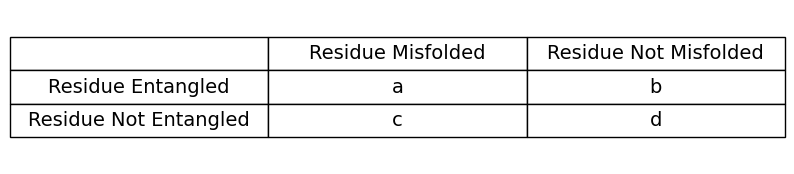

In [5]:
# print a blank contingency table in the format needed for this hypothesis
contingency_table = pd.DataFrame({"Residue Misfolded"    : ["a", "c"], 
                                  "Residue Not Misfolded": ["b", "d"]},
                                 index = ["Residue Entangled", "Residue Not Entangled"])

# print the output
print ("This is our (blank) contingency table:\n")

# create a table from our contingency_table using matplotlib
plt.clf()
fig, ax    = plt.subplots(figsize = (5, 2))
ax.axis("tight")
ax.axis("off")
cell_text  = contingency_table.reset_index().values.tolist()
col_labels = [""] + contingency_table.columns.tolist()
table      = ax.table(cellText=cell_text, colLabels=col_labels, loc="center", cellLoc="center")
table.auto_set_font_size(False)
table.set_fontsize(14)  
table.scale(2, 2)  
plt.show()

* This table is identical in format to the one employed in **Application 1.1** except "protein" is replaced by "residue"
* Run the cell below to complete the analysis

This is our contingency table:



<Figure size 640x480 with 0 Axes>

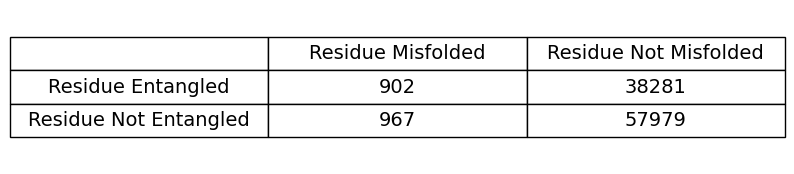

The odds ratio is: 1.41
The p-value is   : 1.85e-13


In [6]:
# compute the values of {a, b, c, d} and construct the contingency table
a = len(data3_filtered[(data3_filtered["region"] == True ) & (data3_filtered["cut_C_Rall"] == True )])
b = len(data3_filtered[(data3_filtered["region"] == True ) & (data3_filtered["cut_C_Rall"] == False)])
c = len(data3_filtered[(data3_filtered["region"] == False) & (data3_filtered["cut_C_Rall"] == True )])
d = len(data3_filtered[(data3_filtered["region"] == False) & (data3_filtered["cut_C_Rall"] == False)])

# also, put values into a new format to enable a nice print statement
contingency_table = pd.DataFrame({"Residue Misfolded"    : [a, c], 
                                  "Residue Not Misfolded": [b, d]},
                                 index = ["Residue Entangled", "Residue Not Entangled"])

# print the contingency table
print ("This is our contingency table:\n")

# create a table from our contingency_table using matplotlib
plt.clf()
fig, ax    = plt.subplots(figsize = (5, 2))
ax.axis("tight")
ax.axis("off")
cell_text  = contingency_table.reset_index().values.tolist()
col_labels = [""] + contingency_table.columns.tolist()
table      = ax.table(cellText=cell_text, colLabels=col_labels, loc="center", cellLoc="center")
table.auto_set_font_size(False)
table.set_fontsize(14)  
table.scale(2, 2)  
plt.show()

# use the fisher_exact function from scipy.stats to compute the odds ratio and p-value
odds_ratio, fisher_p_value = fisher_exact(contingency_table, alternative = 'two-sided')

print ("The odds ratio is:", '%.2f' %odds_ratio)
print ("The p-value is   :", '%.2e' %fisher_p_value)

### Step 4 - Interpret the results

* Think about how you can state this result in simple language and then try to describe it to someone sitting near you
* Your explanation should include: (1) A conclusion about the association (*i.e.*, is there positive, negative, or no association) & (2) A statement about the significance of the result based on the computed *p*-value